<a href="https://colab.research.google.com/github/yrodriguezmd/Surgical_instruments/blob/main/Inference/Surg_instruments_inference_gradio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Inference from a saved model

In [ ]:
!wget https://raw.githubusercontent.com/airctic/icevision/master/icevision_install.sh
!bash icevision_install.sh cuda11 master

In [ ]:
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

In [ ]:
import icevision

In [ ]:
from icevision.all import *

In [ ]:
print('icevision v',icevision.__version__)
print('torch v',torch.__version__)
print('torchvision v',torchvision.__version__)

icevision v 0.11.0
torch v 1.10.0+cu111
torchvision v 0.11.1+cu111


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


In [ ]:
root_dir = Path('/content/gdrive/My Drive/')

In [ ]:
#!git clone https://github.com/yrodriguezmd/Surgical_instruments.git

In [ ]:
classes = ['Army_navy', 'Bulldog', 'Castroviejo','Forceps', 'Frazier', 'Hemostat','Iris','Mayo_metz','Needle','Potts','Richardson','Scalpel','Towel_clip', 'Weitlaner','Yankauer']
class_map = ClassMap(classes)
len(class_map)

16

In [ ]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

from icevision.models.checkpoint import *

model_type = models.mmdet.vfnet ##
backbone = model_type.backbones.resnet50_fpn_mstrain_2x##

In [ ]:
!ls gdrive/MyDrive/Surgical_instruments/Models

Model_M_set11_ret_nov8_map63.6.pth  VFNet_nov13_mAP81.5.pth
Model_M_set11_vf_nov8_map61.1.pth   VFNet_teacher_nov29_mAP82.6.pth
RetinaNet_nov13_mAP64.1.pth	    YOLOv5_nov14_mAP66.6.pth
VFNet_1x_nov14_mAP79.9.pth	    YOLOX_nov14_mAP64.2.pth
VFNet_2x_mAP68.8.pth


In [ ]:
from icevision.models import *

checkpoint_path = root_dir/'Surgical_instruments/Models/VFNet_teacher_nov29_mAP82.6.pth' 

checkpoint_and_model = model_from_checkpoint(checkpoint_path)

model_loaded = checkpoint_and_model["model"]

In [ ]:
!ls gdrive/MyDrive/Surgical_instruments/Second_set.v1i.coco

README.dataset.txt  README.roboflow.txt  test  train  valid


In [ ]:
path = Path('gdrive/MyDrive/Surgical_instruments/Second_set.v1i.coco') # 

test_parser = parsers.COCOBBoxParser(
    annotations_filepath = path/'test/_annotations.coco.json',
    img_dir = path/'test')

whole = SingleSplitSplitter()

test_records, *_ = test_parser.parse(data_splitter = whole)

#show_records(test_records[0:3],ncols=3, font_size=30, label_color = '#ffff00')

In [ ]:
img_size = checkpoint_and_model["img_size"]

valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(img_size), tfms.A.Normalize()])

#infer_ds = Dataset.from_images(imgs_array, valid_tfms, class_map = class_map)
infer_ds = Dataset(test_records, valid_tfms)#, class_map = class_map)

In [ ]:
infer_dl = model_type.infer_dl(infer_ds, 
                               batch_size=4, shuffle=False)

preds_saved_test = model_type.predict_from_dl(model_loaded,#
                                              infer_dl,
                                          keep_images=True, 
                                         detection_threshold = 0.5) ##

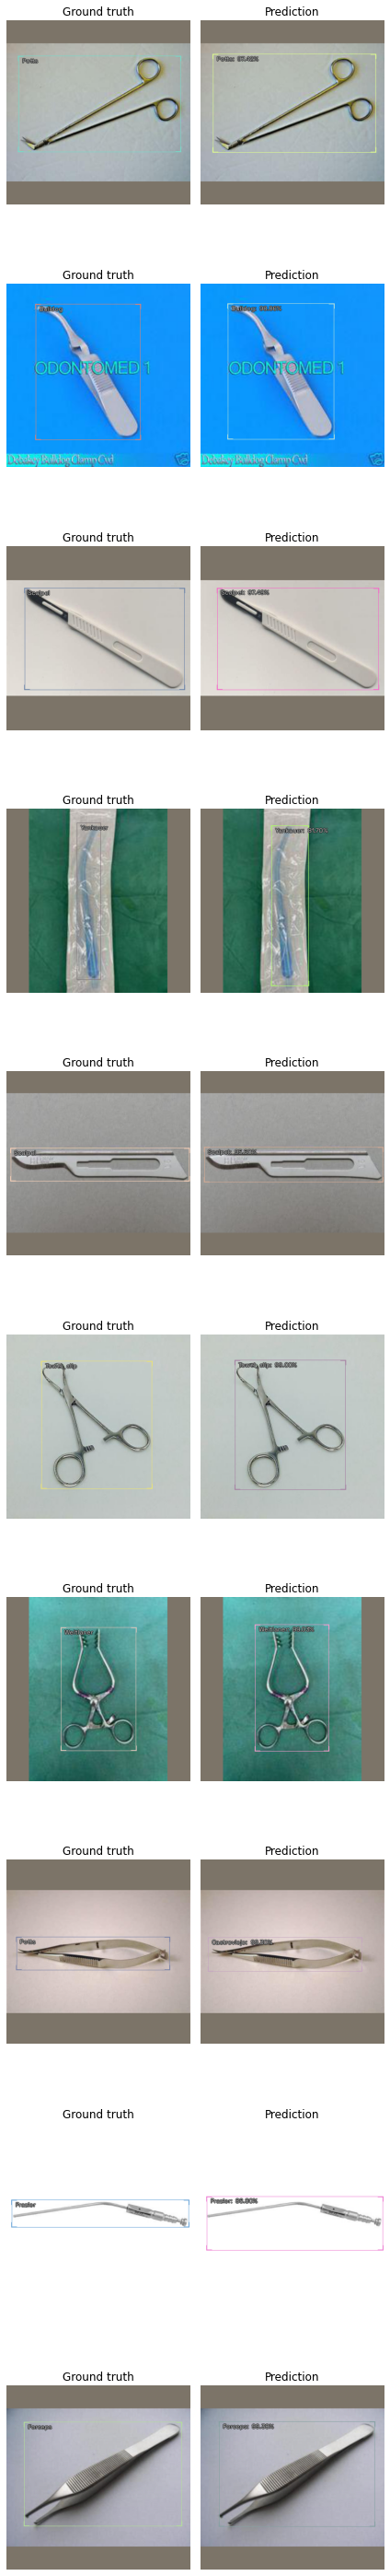

In [ ]:
show_preds(preds = preds_saved_test[0:10])
# with detection threshold 0.5

Gradio deployment using saved model

In [ ]:
!echo "- Installing gradio"
!pip install gradio -U -q

In [ ]:
import icedata
import PIL, requests
import torch
from torchvision import transforms
import gradio as gr

In [ ]:
def show_preds_gradio(input_image, display_label, display_bbox, detection_threshold):

    if detection_threshold==0: detection_threshold=0.5

    img = PIL.Image.fromarray(input_image, 'RGB')

    pred_dict  = model_type.end2end_detect(img, 
                                           valid_tfms, 
                                           model_loaded, ## 
                                           class_map=class_map, 
                                           detection_threshold=detection_threshold,
                                           display_label=display_label, 
                                           display_bbox=display_bbox, 
                                           return_img=True, 
                                           font_size=16, 
                                           label_color="#FF59D6")

    return pred_dict['img']

In [ ]:
display_chkbox_label = gr.inputs.Checkbox(label="Label", default=True)
display_chkbox_box = gr.inputs.Checkbox(label="Box", default=True)

detection_threshold_slider = gr.inputs.Slider(minimum=0, maximum=1, step=0.1, default=0.5, label="Detection Threshold")

outputs = gr.outputs.Image(type="pil")

# Option 1: Get an image from local drive
gr_interface = gr.Interface(fn=show_preds_gradio, inputs=["image", display_chkbox_label, display_chkbox_box,  detection_threshold_slider], outputs=outputs, title='IceApp - COCO')

In [ ]:
gr_interface.launch(inline=False, share=True, debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://13840.gradio.app

This share link will expire in 72 hours. To get longer links, send an email to: support@gradio.app


KeyboardInterrupt: ignored